In [1]:
import torch
from torch import nn
import circuits as ckt

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 3 nodes and 3 elements
[0, 1, 2]
[(2 , 0), (1 , 0), (2 , 1)]
[(2, {}), (0, {}), (1, {})]
[(2, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': None, 'v': None, 'attr': 1}), (2, 1, 0, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': 1000000.0}), (1, 0, 0, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': 1000000.0})]


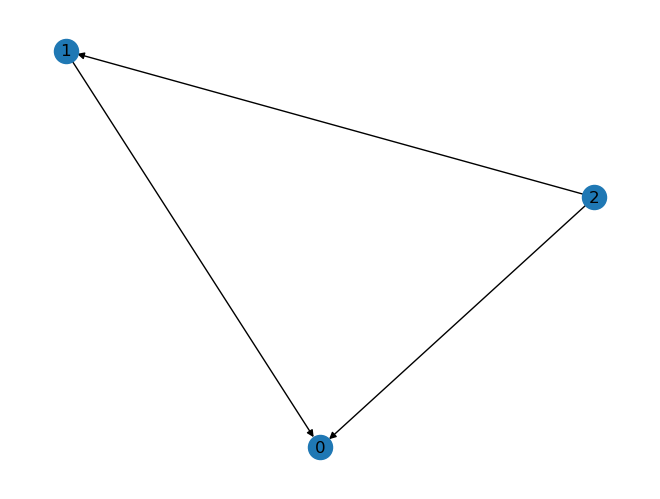

In [3]:
vr = ckt.Circuit()

# v_source = vr.add_element(kind=ckt.Kinds.IVS)
# r1 = vr.add_element(kind=ckt.Kinds.R)
# v_source.connect(v_source.high, r1.high)
# v_source.connect(v_source.low, r1.low)
# v_source.attr = 1
# r1.attr = 1e6

v_source = vr.add_element(kind=ckt.Kinds.IVS)
r1 = vr.add_element(kind=ckt.Kinds.R)
r2 = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, r1.high)
r1.connect(r1.low, r2.high)
v_source.connect(v_source.low, r2.low)
v_source.attr = 1
r1.attr = 1e6
r2.attr = 1e6

print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Expected Sizes of Vectors

In [4]:
print(f'size of element currents, voltages, and attr = ({vr.num_elements()},1)')
print(f'size of node voltages = ({vr.num_nodes()},1)')

size of element currents, voltages, and attr = (3,1)
size of node voltages = (3,1)


# Inputs

In [5]:
input_test = ckt.Input(vr)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:67: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [6]:
input_test.M

tensor([[-1., -1.,  0.],
        [ 1.,  0.,  1.],
        [ 0.,  1., -1.]])

In [7]:
input_test.M_red

tensor([[-1., -1.,  0.],
        [ 1.,  0.,  1.]])

# Circuit Theory Functions

In [8]:
init_params = input_test.init_params()
init_params

(Parameter containing:
 tensor([[0.5022],
         [0.6269],
         [0.4355]], requires_grad=True),
 Parameter containing:
 tensor([[1.0000],
         [0.3148],
         [0.3748]], requires_grad=True),
 Parameter containing:
 tensor([[0.9975],
         [0.8279],
         [0.0228]], requires_grad=True),
 Parameter containing:
 tensor([[1.0000e+00],
         [1.0000e+06],
         [1.0000e+06]], requires_grad=True))

In [9]:
input_test.X_row(init_params[ckt.Props.Attr.value])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.0000e+06,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+06,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<AddBackward0>)

In [10]:
input_test.kinds_map

{<Kinds.IVS: 0>: [True, False, False],
 <Kinds.ICS: 1>: [False, False, False],
 <Kinds.R: 2>: [False, True, True]}

In [11]:
input_test.s(init_params[ckt.Props.Attr.value])

tensor([1., 0., 0.], grad_fn=<IndexPutBackward0>)

# Define Models

In [12]:
torch.zeros_like(input_test.M)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [13]:
torch.eye(input_test.circuit.num_elements())

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [14]:
-input_test.M_red.T

tensor([[ 1., -1.],
        [ 1., -0.],
        [-0., -1.]])

In [15]:
class Solve():
    ''' 
    Sparse Tableau Formulation of circuit analysis, modeled as a machine learning
    problem to learn element attributes using backprop and optimization.
    '''
    def __init__(self, input: ckt.Input, attr:nn.Parameter):
        super().__init__()
        self.input = input
        self.attr = attr.clone().detach().requires_grad_(False)
        

    def solve(self):
        A,b = self.build()
        return torch.linalg.solve(A,b)

    def build(self):
        # inputs
        s = self.input.s(self.attr)
        M = self.input.M
        M_red = self.input.M_red
        num_elements = self.input.circuit.num_elements()
        num_nodes = self.input.circuit.num_nodes()
                
        # A matrix
        kcl_row = torch.cat(tensors=(M_red,
                                    torch.zeros_like(M_red),
                                    torch.zeros_like(M_red[:,:-1])),dim=1)
        kvl_row = torch.cat(tensors=(torch.zeros_like(M),
                                    torch.eye(num_elements),
                                    -M_red.T),dim=1)
        e_row = self.input.X_row(self.attr)
        A = torch.cat(tensors=(kcl_row,kvl_row,e_row), dim=0)
        print(A)

        # b matrix
        kcl_zeros = torch.zeros(num_nodes - 1)
        kvl_zeros = torch.zeros(num_elements)
        b = torch.cat(tensors=(kvl_zeros,kcl_zeros,s), dim=0)
        print(b)
        
        return A,b

# Create Solver

In [16]:
import time
input = ckt.Input(vr)
start_time = time.time()
_,_,_,attr_param = input.init_params()
model = Solve(input=input,attr=attr_param)
solution = model.solve()
end_time = time.time()

tensor([[-1.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00, -1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00, -0.0000e+00, -1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.0000e+06,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+06,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([0., 0.,

In [17]:
print(f'execution time = {(end_time - start_time)*1000} ms')

execution time = 2.0072460174560547 ms


In [18]:
solution

tensor([-5.0000e-07,  5.0000e-07,  5.0000e-07,  1.0000e+00,  5.0000e-01,
         5.0000e-01, -5.0000e-01,  5.0000e-01])

# Solver with Optimizer